In [51]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import time
import math

from pprint import pprint

In [34]:
class MyGraph:
    def __init__(self, nodes: int = 5, max_edge: int = 5):
        self.nodes = nodes  # y-axis
        # adj = np.eye(5)
        # adj = np.roll(adj, 1, axis=1)
        # adj = adj.T+adj
        self.G = nx.from_numpy_array(
            self.construct_random_subgraph(self.nodes, max_edges=max_edge),
            # adj,
            create_using=nx.DiGraph(),
        )
        self.adj_matrix = nx.adjacency_matrix(self.G).toarray()
        self.adjacency_dict = {k: list(v) for k, v in self.G.adjacency()}
        self.nodes_list = list(self.G.nodes.keys())
        self.edge_indices = self.calc_node_action_pairs()
        self.state_dim = nodes
        self.action_dim = None

    def construct_random_subgraph(self, num_nodes, min_edges=2, max_edges=5):
        min_edges -= 1
        max_edges -= 1
        connections = np.random.uniform(size=(num_nodes, num_nodes))
        connections += np.roll(
            np.eye(num_nodes), 1, 1
        )  # make sure every node is connected
        connections -= np.eye(num_nodes)  # make sure no self-connections
        # set strongest connections
        sorted_connections = np.sort(connections)[:, ::-1]
        min_edges = min_edges
        max_edges = max_edges + 1
        min_edges = int(min_edges / 2 + 0.5)  # used to be min_edges // 2
        max_edges = int(max_edges / 2 + 0.5)
        indices = np.stack(
            [np.arange(num_nodes), np.random.randint(min_edges, max_edges, num_nodes)]
        )
        thresholds = sorted_connections[indices[0], indices[1]]
        connections = np.where(connections > thresholds[:, None], 1.0, 0.0).astype(
            np.float32
        )
        connections = np.clip(connections + connections.T, 0, 1)
        return connections

    def calc_node_action_pairs(self) -> dict[(int, int) : int]:
        edge_indices = {}
        for edge_idx, edge in enumerate(self.G.edges()):
            # from_node, to_node = edge
            # from_node_idx = self.nodes_list.index(from_node)
            # to_node_idx = self.nodes_list.index(to_node)
            edge_indices[edge] = edge_idx
        return edge_indices

    def calc_action_between_cur_and_next_node(
        self, curr_node: int, next_node: int
    ) -> int:
        """
        each node has 4 actions: [S, N, W, E]
        """
        curr_x, curr_y = self.nodes_list[curr_node]
        next_x, next_y = self.nodes_list[next_node]
        origin_neighbors = [
            (curr_x + 1, curr_y),
            (curr_x - 1, curr_y),
            (curr_x, curr_y - 1),
            (curr_x, curr_y + 1),
        ]
        action = origin_neighbors.index((next_x, next_y))
        return action

    def random_walk(self):
        dataset = []
        for src, tgts in self.adjacency_dict.items():
            for tgt in tgts:
                if tgt > src:
                    delta_state = np.zeros(self.state_dim)
                    delta_state[src] = -1
                    delta_state[tgt] = 1
                    dataset.append(delta_state.copy())
        self.action_dim = len(dataset)
        return np.array(dataset, dtype=np.float32)

In [4]:
class GraphDataset(Dataset):
    def __init__(self, dataset, n_obs):
        self.dataset = torch.from_numpy(dataset).type(torch.float32).to("cuda")

    def __getitem__(self, index):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)

In [5]:
class MyNNCML(nn.Module):
    def __init__(
        self,
        emb_dim,
        n_obs,
        n_act,
        use_nn: bool = False,
        hidden=128,
    ):
        super().__init__()
        self.use_nn = use_nn
        self.n_act = n_act
        self.n_obs = n_obs
        if use_nn:
            self.Q = nn.Sequential(
                nn.Linear(self.n_obs, hidden, bias=True),
                nn.ReLU(),
                nn.Linear(hidden, emb_dim, bias=True),
                nn.Tanh()
            )
            self.decoder = nn.Sequential()
        else:
            self.Q = nn.Linear(n_obs, emb_dim, bias=False)
            self.decoder = nn.Linear(emb_dim, n_obs, bias=False)

    def forward(self, delta_state: torch.Tensor):
        output = self.Q(delta_state)
        recon = self.decoder(output)
        return output

In [65]:
def CML_planner(graph: MyGraph, start: int, goal: int, model: MyNNCML):
    node_record = []    
    curr = start
    tgt = torch.zeros(graph.state_dim, dtype=torch.float32)
    tgt[start] = -1
    tgt[goal] = 1
    tgt_emb = model(tgt.to('cuda'))
    for i in range(graph.action_dim):
        node_record.append(curr)
        if curr == goal:
            return i, node_record
        tgt = torch.zeros(graph.state_dim, dtype=torch.float32)
        tgt[curr] = -1
        tgt[goal] = 1
        tgt_emb = model(tgt.to('cuda'))
        temp_max = -np.inf
        idx_max = -1
        for next_node in graph.adjacency_dict[curr]:
            if next_node not in node_record:
                now = torch.zeros(graph.state_dim, dtype=torch.float32)
                now[curr] = -1
                now[next_node] = 1
                now_emb = model(now.to('cuda'))
                now_emb = now_emb / now_emb.norm()
                dot_prod = now_emb @ tgt_emb
                if dot_prod > temp_max:
                    temp_max = dot_prod
                    idx_max = next_node
        if idx_max == -1:
            print("planning failed")
            raise ValueError
        curr = idx_max
        
    return i, node_record

In [7]:
def orthogonality_loss(output):
    """
    Orthogonality loss to enforce outputs of a neural network to be orthogonal.

    Args:
        outputs (torch.Tensor): A tensor of shape (B, D) where B is the batch size
                                and D is the dimensionality of the outputs.
    Returns:
        torch.Tensor: The orthogonality loss scalar.
    """
    # Normalize the outputs row-wise
    outputs_normalized = output / output.norm(dim=1, keepdim=True)

    # Compute the Gram matrix
    # TODO: abs norm
    gram_matrix = torch.matmul(outputs_normalized, outputs_normalized.T)
    # gram_matrix = torch.matmul(output, output.T)

    # Create an identity matrix of the same size as the Gram matrix
    identity_matrix = torch.eye(gram_matrix.size(0), device=output.device)

    # Compute the Frobenius norm of the difference between Gram and Identity
    loss = torch.mean((gram_matrix - identity_matrix)**2)
    # loss = torch.norm(gram_matrix - torch.diag(gram_matrix), p="fro") ** 2

    return loss

In [40]:
map_size = 5
my_graph = MyGraph(map_size)
num_walks = 200
walk_length = map_size
dataset = my_graph.random_walk()
n_obs = my_graph.state_dim
n_act = my_graph.action_dim
print(n_obs, n_act)
dataset[0]

5 6


array([-1.,  1.,  0.,  0.,  0.], dtype=float32)

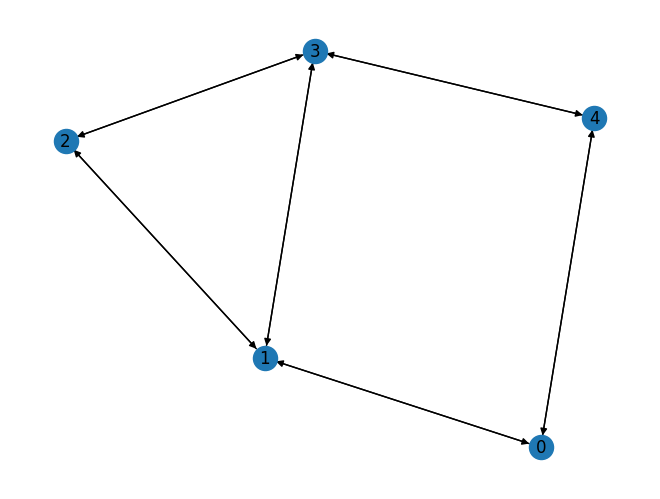

In [42]:
nx.draw(my_graph.G, with_labels=True)

In [43]:
n_obs = my_graph.state_dim
n_act = my_graph.action_dim
emb_dim = 10
hidden = 10
use_nn = True
num_epochs = 10
batch_size = n_act
dataset_torch = GraphDataset(dataset, n_obs)
lr = 1e-3
loader = DataLoader(dataset_torch, shuffle=True, batch_size=batch_size)
n_obs, n_act, n_act == len(dataset_torch)

(5, 6, True)

In [44]:
model = MyNNCML(
    emb_dim,
    n_obs,
    n_act,
    use_nn=use_nn,
    hidden=hidden,
)
# def init_weight(m):
#     nn.init.normal_(m.weight, 0, 1e-1)
# model.Q.apply(init_weight)
# with torch.no_grad():
#     print(model.Q.weight.mean(), model.Q.weight.var())
optim = torch.optim.AdamW(model.parameters(), lr=lr)
writer = SummaryWriter(f"""state_only/{time.time()}""")
global_step = 0


In [45]:
model.to("cuda")
model.train()
for epoch in range(2000):
    for i, data in enumerate(loader):
        # print(i)
        output = model(data)
        loss = orthogonality_loss(output)
        optim.zero_grad()
        # loss += torch.mean((torch.norm(output, dim=1) - .1) ** 2)
        # loss += torch.mean(((model.Q.weight.T @ model.Q.weight) - torch.eye(n_obs, device=output.device)) ** 2)
        loss.backward()
        optim.step()
        global_step += 1
        # with torch.no_grad():
        #     model.Q.weight /= torch.linalg.norm(model.Q.weight, axis=1, keepdim=True)
        writer.add_scalar("train loss", loss.detach().item(), global_step)

In [46]:
with torch.no_grad():
    model.eval()
    # print(orthogonality_loss(output))
    # print(model(dataset_torch[:5])@model(dataset_torch[:5]).T)
    emb = model(dataset_torch[:])
    print(emb[:].norm(dim=1))
    emb_norm = emb/emb.norm(dim=1, keepdim=True)
    # print(emb_norm)
    # print(emb_norm[:]@emb_norm[:].T)
    gram_matrix = torch.matmul(emb_norm, emb_norm.T)
    identity_matrix = torch.eye(gram_matrix.size(0), device=output.device)
    print(torch.max(gram_matrix - identity_matrix), gram_matrix.size(0))
    # print(model(dataset_torch[:]).norm(dim=1))
    # print(model(dataset_torch[:5]))
    # print(model.Q.weight.mean(), model.Q.weight.var())

tensor([0.5239, 0.1951, 0.4821, 0.4713, 0.4574, 0.3798], device='cuda:0')
tensor(1.8653e-05, device='cuda:0') 6


In [56]:
torch.set_printoptions(precision=4,sci_mode=False, linewidth=100)

In [57]:
# pprint(dataset_torch[:], emb, gram_matrix)
pprint(gram_matrix, width=200)

tensor([[     1.0000,     -0.0000,      0.0000,      0.0000,      0.0000,      0.0000],
        [    -0.0000,      1.0000,     -0.0000,      0.0000,      0.0000,     -0.0000],
        [     0.0000,     -0.0000,      1.0000,      0.0000,     -0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,      1.0000,      0.0000,      0.0000],
        [     0.0000,      0.0000,     -0.0000,      0.0000,      1.0000,      0.0000],
        [     0.0000,     -0.0000,      0.0000,      0.0000,      0.0000,      1.0000]],
       device='cuda:0')


In [24]:
test_vec = torch.Tensor([0, -1, 1, 0, 0]).to('cuda')
test_emb = model(test_vec)
test_emb @ model(dataset_torch[0]), test_emb @ model(-dataset_torch[2])

(tensor(0.0723, device='cuda:0', grad_fn=<DotBackward0>),
 tensor(0.1099, device='cuda:0', grad_fn=<DotBackward0>))

In [76]:
model.Q.weight.T @ model.Q.weight

tensor([[0.2193, 0.1729, 0.1725,  ..., 0.0307, 0.0642, 0.1592],
        [0.1729, 0.2723, 0.1976,  ..., 0.0290, 0.0477, 0.1296],
        [0.1725, 0.1976, 0.2886,  ..., 0.0450, 0.0497, 0.1259],
        ...,
        [0.0307, 0.0290, 0.0450,  ..., 0.6597, 0.2262, 0.0621],
        [0.0642, 0.0477, 0.0497,  ..., 0.2262, 0.4393, 0.1278],
        [0.1592, 0.1296, 0.1259,  ..., 0.0621, 0.1278, 0.2611]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [61]:
with torch.no_grad():
    model.eval()
    N_goal = 2000
    cml_distance = []
    cml_succ = 0
    dijkstra_distance = []
    graph = nx.from_numpy_array(
        my_graph.adj_matrix, create_using=nx.DiGraph()
    )  # node_id is int, or else dijkstra will fail
    for process in range(N_goal):
        print(process)
        start = np.random.randint(low=0, high=my_graph.adj_matrix.shape[0])
        goal = np.random.randint(low=0, high=my_graph.adj_matrix.shape[0])
        # print(start, goal)

        steps, o_record = CML_planner(my_graph, start, goal, model)

        dijkstra_path = nx.shortest_path(
            graph, source=start, target=goal, weight="weight"
        )
        dijkstra_steps = len(dijkstra_path) - 1

        dijkstra_distance.append(dijkstra_steps)
        if o_record[-1] == goal:
            cml_distance.append(steps)
            cml_succ += 1
        if dijkstra_steps < steps:
            print(o_record, dijkstra_path)
            break
        print(steps, dijkstra_steps)
    print(np.mean(cml_distance), np.mean(dijkstra_distance), cml_succ)

0
2 2
1
1 1
2
0 0
3
0 0
4
2 2
5
2 2
6
2 2
7
1 1
8
1 1
9
1 1
10
1 1
11
2 2
12
1 1
13
2 2
14
1 1
15
2 2
16
1 1
17
1 1
18
1 1
19
1 1
20
2 2
21
1 1
22
[3, 2, 1, 0] [3, 1, 0]
1.3478260869565217 1.3043478260869565 23


In [ ]:
writer.add_text(
    "result",
    f"""{"nnCML" if use_nn else "CML"}, \n map_size: {str(map_size)}, n_obs: {n_obs}, n_act: {n_act}, \n hidden: {str(hidden) if use_nn else "0"}, embed: {str(emb_dim)}, BS: {str(batch_size)}, \n **CML_AL**: {np.mean(cml_distance)}, **dj_AL**: {np.mean(dijkstra_distance)}, **SR**: {cml_succ / N_goal}""",
)

In [67]:
start = 3
goal = 0

steps, o_record = CML_planner(my_graph, start, goal, model)

dijkstra_path = nx.shortest_path(
    graph, source=start, target=goal, weight="weight"
)
dijkstra_steps = len(dijkstra_path) - 1

dijkstra_distance.append(dijkstra_steps)
if o_record[-1] == goal:
    cml_distance.append(steps)
    cml_succ += 1
if dijkstra_steps < steps:
    print(o_record, dijkstra_path)
print(steps, dijkstra_steps)

[3, 2, 1, 0] [3, 1, 0]
3 2
